<a href="https://colab.research.google.com/github/nhamhung/Coder-School-Machine-Learning/blob/master/%5BHung%5D_of_FTMLE_Deep_Neural_Network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network from scratch

![](https://miro.medium.com/max/3288/1*zTBAO0amYqZs2DMhLCrBnA.png)


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, accuracy_score

np.random.seed(1) # set a seed so that the results are consistent

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Load the data from h5 file
def load_dataset():
    train_dataset = h5py.File('/content/gdrive/My Drive/FTMLE - Philippines/Data/catvnoncat/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('/content/gdrive/My Drive/FTMLE - Philippines/Data/catvnoncat/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

In [ ]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [ ]:
test_set_x_orig.shape

(50, 64, 64, 3)

In [ ]:
train_set_y_orig.shape

(1, 209)

In [ ]:
test_set_y_orig.shape

(1, 50)

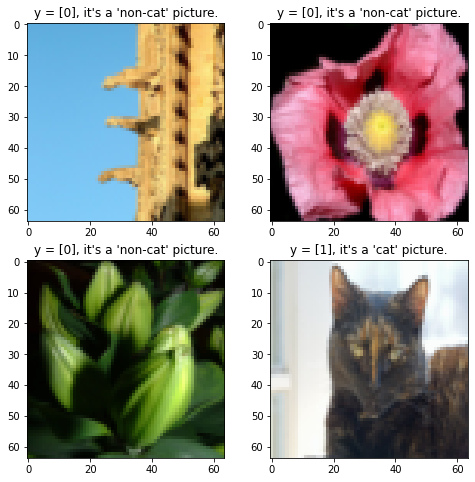

In [ ]:
# Some some random images and their labels
plt.subplots(figsize = (8,8))
plt.subplot(221)
index_1 = np.random.randint(0,len(train_set_x_orig)) 
plt.imshow(train_set_x_orig[index_1])
plt.title("y = " + str(train_set_y_orig[:, index_1]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index_1])].decode("utf-8") +  "' picture.")

plt.subplot(222)
index_2 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_2])
plt.title("y = " + str(train_set_y_orig[:, index_2]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index_2])].decode("utf-8") +  "' picture.")

plt.subplot(223)
index_3 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_3])
plt.title("y = " + str(train_set_y_orig[:, index_3]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index_3])].decode("utf-8") +  "' picture.")

plt.subplot(224)
index_4 = np.random.randint(0,len(train_set_x_orig))
plt.imshow(train_set_x_orig[index_4])
plt.title("y = " + str(train_set_y_orig[:, index_4]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index_4])].decode("utf-8") +  "' picture.")

plt.show()

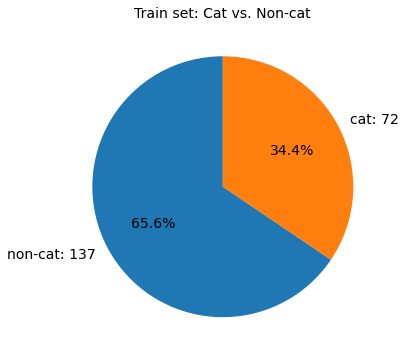

In [ ]:
# Visualization the train set labels
unique, counts = np.unique(train_set_y_orig, return_counts = True)
dict1 = dict(zip(unique, counts))
plt.figure(figsize=(6,6))
plt.pie(x = counts, labels = ['non-cat: %s' % counts[0],'cat: %s' % counts[1]], autopct = '%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Train set: Cat vs. Non-cat', fontdict={'fontsize': 14})
plt.show()

In [ ]:
# Convert X to 2D array
X_train = train_set_x_orig.flatten().reshape((len(train_set_x_orig),-1)) / 255
X_test = test_set_x_orig.flatten().reshape((len(test_set_x_orig),-1)) / 255

# Convert y to 1D array
y_train = train_set_y_orig.reshape(1, -1)
y_test = test_set_y_orig.reshape(1, -1)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((209, 12288), (1, 209), (50, 12288), (1, 50))

## Before you start...

![](https://i.imgur.com/ivhZhmx.png)

**Notation**:
- Superscript $[L]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[L]}_i$ denotes the $i^{th}$ entry of the $L^{th}$ layer's activations).
    
The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_params`, you should make sure that your dimensions match between each layer. Given $n^{[L]}$ is the number of units in layer $L$. Thus for example if the size of our input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

| |**Shape of W**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |**Shape of b**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|**Shape of Activation**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|:-|:-|:-|:-|:-|
|**Layer 1**|$(n^{[1]},12288)$|$(n^{[1]},1)$|$Z^{[1]} = W^{[1]}  X + b^{[1]} $|$(n^{[1]},209)$|
| **Layer 2**|$(n^{[2]}, n^{[1]})$|$(n^{[2]},1)$|$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$|$(n^{[2]}, 209)$|
|$\vdots$| $\vdots$ | $\vdots$|$\vdots$|$\vdots$|
|**Layer L-1** | $(n^{[L-1]}, n^{[L-2]})$ | $(n^{[L-1]}, 1)$ | $Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ | $(n^{[L-1]}, 209)$|
|**Layer L** | $(n^{[L]}, n^{[L-1]})$ | $(n^{[L]}, 1)$|  $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$|$(n^{[L]}, 209)$ |

Remember that when we compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    j  & k  & l\\
    m  & n & o \\
    p  & q & r 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    a  & b  & c\\
    d  & e & f \\
    g  & h & i 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    s  \\
    t  \\
    u
\end{bmatrix}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (ja + kd + lg) + s  & (jb + ke + lh) + s  & (jc + kf + li)+ s\\
    (ma + nd + og) + t & (mb + ne + oh) + t & (mc + nf + oi) + t\\
    (pa + qd + rg) + u & (pb + qe + rh) + u & (pc + qf + ri)+ u
\end{bmatrix}$$

**Mathematical expression of the algorithm**:

![](https://i.imgur.com/FPjpVDX.png)

## Implementation of Deep Neural Network

### Helper Functions

In [ ]:
def sigmoid(Z):
    '''Implement the sigmoid function'''
    # Your code here
    return 1 / (1 + np.exp(-Z))

In [ ]:
def relu(Z):
    '''Implement the relu function'''
    # Your code here
    return np.maximum(0, Z)

In [ ]:
def relu_backward(Z):
    Z[Z<=0] = 0
    Z[Z>0] = 1
    return Z

In [ ]:
# def relu_backward(Z):
#     '''Derivative of the relu function'''
#     # Your code here
#     return 1 if Z > 0 else 0

In [ ]:
def layer_sizes(X, Y, hidden_layers):
    '''Create a list of number of nodes in each layers including Input and Output layers

    Arguments:
        X, Y: training data
        hidden_layers: a list of number of nodes in hidden layers

    Example:
    >>> X.shape, Y.shape
    (209, 12288), (1, 209)
    >>> layer_sizes(X_train, y_train, [20, 5, 7])
    array([12288,    20,     5,     7,     1])
    '''

    layer_dims = np.array(hidden_layers, copy=True)

    # Number of input and output
    # Your code here
    n_x = X.shape[1]
    n_y = Y.shape[0]

    # Respectively insert and append n_x and n_y to layer_dims
    # Your code here
    # Hint: np.insert and np.append
    layer_dims = np.insert(layer_dims, 0, n_x)
    layer_dims = np.append(layer_dims, n_y)

    return layer_dims

layer_dims = layer_sizes(X_train, y_train, [20, 5, 7])

# Expected Result:
# array([12288,    20,     5,     7,     1])

To understand more about how to initialize parameters in a Deep Neural Network, read [this article](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78). 

In [ ]:
def initialize_params(layer_dims):
    '''Initialize W and b of every layer

    Arguments:
        layer_dims: list of number of nodes in each layers including Input and Output layers
                    Output of layer_sizes() function
    Return:
        parameters: a dictionary that contains the weights and biases of each layer
            parameters['W' + str(i)] defines the weights of the ith layer where Input layer has i=0
            parameters['b' + str(i)] defines the biases of the ith layer
    '''

    # Set random seed to 102
    # Your code here
    np.random.seed(102)

    # Create an empty dictionary parameters to store the weights and biases
    # Your code here
    parameters = {}

    # Loop through layers
    L = len(layer_dims)
    
    for i in range(1, L):
        # Initialize weight and bias at each layer
        # Your code here
        parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) * np.sqrt(2/layer_dims[i - 1]) # Use He initialization (Refer to link above)
        parameters['b' + str(i)] = np.zeros((layer_dims[i], 1)) # Initialize at 0
        print(parameters['W' + str(i)].shape, parameters['b' + str(i)].shape)

        # Write assert to check the shape of each layer
        # Your code here
        assert parameters['W' + str(i)].shape == (layer_dims[i], layer_dims[i - 1])
        assert parameters['b' + str(i)].shape == (layer_dims[i], 1)

    return parameters

In [ ]:
X_train.shape

(209, 12288)

In [ ]:
parameters = initialize_params(layer_dims)

(20, 12288) (20, 1)
(5, 20) (5, 1)
(7, 5) (7, 1)
(1, 7) (1, 1)


In [ ]:
parameters

{'W1': array([[ 0.0201432 ,  0.00765352,  0.01214112, ..., -0.00541534,
         -0.00024024, -0.00482429],
        [ 0.02086388,  0.00877511, -0.00939157, ..., -0.03009446,
         -0.00945971,  0.0081965 ],
        [ 0.0065029 , -0.02382468, -0.01570248, ..., -0.0190859 ,
         -0.02301782,  0.01516806],
        ...,
        [ 0.00032547,  0.0041729 , -0.02732608, ..., -0.01168898,
          0.01370899,  0.01595812],
        [-0.00795288,  0.00693842, -0.0136769 , ..., -0.01492964,
         -0.00477362, -0.00500983],
        [-0.02350254, -0.01268792, -0.03171646, ...,  0.01702753,
         -0.01093975, -0.01363381]]),
 'W2': array([[-0.306789  ,  0.25132937,  0.24576932,  0.06764679,  0.75301473,
          0.2713798 ,  0.60465562, -0.40794712, -0.32630937,  0.03801084,
         -0.19257151,  0.6555933 , -0.29746891,  0.54709669,  0.08733661,
         -0.0709107 ,  0.82437638, -0.50900923,  0.2171221 , -0.07162204],
        [ 0.31231937, -0.51111647, -0.32942469,  0.02000004, -0.

### Foward Propagation

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[L]} = W^{[L]}A^{[L-1]} +b^{[L]}$$

where $A^{[0]} = X^T$. And the activation functions:

$$A = ReLU(Z) = max(0, Z)$$
$$A^{[L]} = sigmoid(Z^{[L]})$$

In [ ]:
list(range(1, 5))

[1, 2, 3, 4]

In [ ]:
def forward_propagation(X, parameters):
    '''Implement forward propagation

    Arguments:
        X: training data
        parameters: a dictionary that contains the weights and biases of each layer

    Return:
        A_last: Output of the Output layer
        caches: a dictionary that contains Z and A of each layer
            caches['A' + str(i)] is the output of layer ith
            caches['Z' + str(i)] is the linear combination of input of layer ith
    '''

    # Determine the number of layers L
    L = len(parameters) // 2 + 1

    # Create an empty dictionary caches
    # Your code here
    caches = {}

    # The initial value of A is the input layer
    A_prev = X.T

    # Calculate Zi and Ai of all hidden layers in a for loop
    for i in range(1, L):

        # Get the weights and bias of corresponding layer
        # Your code here
        Wi = parameters[f'W{i}']
        bi = parameters[f'b{i}']

        # Calculate Z of the current layer
        # Your code here
        Zi = np.dot(Wi, A_prev) + bi

        # For every layer before the output layer, use Relu Activation function
        # Your code here
        if i < L - 1:
            Ai = relu(Zi)

        # For the output layer, use Sigmoid function
        # Your code here
        else:
            Ai = sigmoid(Zi)

            # Assign Ai to A_last
            # Your code here
            A_last = Ai
            
        #  Store Ai and Zi in caches
        # Your code here
        caches['A' + str(i)] = Ai
        caches['Z' + str(i)] = Zi

        # Ai will now be the input of the next layer and hence be assigned to A_prev
        # Your code here
        A_prev = Ai
    
    return A_last, caches

In [ ]:
A_last, caches = forward_propagation(X_train, parameters)

In [ ]:
A_last

array([[0.44772765, 0.46347736, 0.4554554 , 0.46784457, 0.45470799,
        0.48326873, 0.48296983, 0.47070253, 0.44402262, 0.43276973,
        0.45413465, 0.45801808, 0.45736887, 0.40480163, 0.46102032,
        0.45118997, 0.4428226 , 0.45850596, 0.46614747, 0.46709912,
        0.47066262, 0.49276937, 0.44275291, 0.45455522, 0.44835626,
        0.48498985, 0.48721598, 0.45649625, 0.45061934, 0.48291819,
        0.45236559, 0.46164018, 0.42921525, 0.47345507, 0.44520165,
        0.47566231, 0.44998298, 0.47023119, 0.51336068, 0.48476378,
        0.4664587 , 0.47747357, 0.43568408, 0.46222434, 0.46328949,
        0.5115155 , 0.44968765, 0.44713461, 0.481813  , 0.46689471,
        0.45709006, 0.46505016, 0.46659548, 0.44869699, 0.5299006 ,
        0.52081097, 0.48143429, 0.45303142, 0.48272062, 0.47866169,
        0.459085  , 0.44019825, 0.47455919, 0.46459742, 0.41988819,
        0.46103491, 0.46885424, 0.47065329, 0.45875403, 0.48274901,
        0.47567846, 0.46805957, 0.50476054, 0.44

### Cost (Loss) function

$$J = -\frac1m\sum \bigg( Y \odot log(A^{[L]}) + (1-Y) \odot log(1-A^{[L]}) \bigg)$$

> Note that $\odot$ denotes elementwise multiplication.

In [ ]:
A_last.shape

(1, 209)

In [ ]:
def compute_cross_entropy_cost(A_last, Y):
    '''Compute the cross entropy cost'''
    # Determine the number of instances m
    # Your code here
    m = A_last.shape[1]

    # Calculate the cost J
    J = -(1/m) * np.sum(Y * np.log(A_last) + (1 - Y) * np.log(1 - A_last))
    return J

In [ ]:
y_train

array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
compute_cross_entropy_cost(A_last, y_train)

0.6788672379476416

### Backward propagation

The three outputs $(dZ^{[L]}, dW^{[L]}, db^{[L]})$ are computed using the input $dZ^{[L]}$.Here are the formulas you need:


$$dZ^{[L]} =   W^{[L+1]^T}dZ^{[L+1]} \odot g^{[L]'}(Z^{[L]})$$

For the last layer:
$$dZ^{[L]}= (A^{[L]} -Y)$$

$$ dW^{[L]} = \frac{\partial \mathcal{L} }{\partial W^{[L]}} = \frac{1}{m} dZ^{[L]} A^{[L-1] T}$$
$$ db^{[L]} = \frac{\partial \mathcal{L} }{\partial b^{[L]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[L](i)}$$






In [ ]:
def backward_propagation(X, Y, parameters, caches):
    '''Implement backward propagation

    Arguments:
        X, Y: training data
        parameters: a dictionary that contains the weights and biases of each layer
        caches: a dictionary that contains Z and A of each layer
    Return:
        grads: gradients of weights and biases at each layer
            grads['dW' + str(i)], grads['db' + str(i)], grads['dZ' + str(i)] are the 
            gradients of W, b, and Z at layer ith
    '''

    # Determine number of instances m
    # Your code here
    m = Y.shape[1]

    # Determine number of layers L
    L = len(parameters) // 2 + 1

    # Create an empty dictionary grads
    # Your code here
    grads = {}

    # Calculate dZ_last, dW_last, db_last of the Output layer
    A_last = caches['A' + str(L-1)] 
    A_last_prev = caches['A' + str(L-2)]

    # Your code here
    dZ_last = A_last - Y
    dW_last = (1/m) * np.dot(dZ_last, A_last_prev.T)
    db_last = (1/m) * np.sum(dZ_last, axis=1, keepdims=True)

    # Save the gradients of the output layer
    # Your code here
    grads['dZ' + str(L-1)] = dZ_last
    grads['dW' + str(L-1)] = dW_last
    grads['db' + str(L-1)] = db_last

    # Loop backward from L-2 to 0 to calculate dZ, dW, db of each layer
    for i in range(L-2, 0, -1):

        # Make sure you understand these parameters clearly
        # Refer to the formula above
        Zi = caches['Z' + str(i)]
        W_next = parameters['W' + str(i+1)]
        dZ_next = grads['dZ' + str(i+1)]
        A_prev = caches['A' + str(i-1)] if i>1 else X.T

        # Your code here
        dZi = np.dot(W_next.T, dZ_next) * relu_backward(Zi)
        dWi = (1/m) * np.dot(dZi, A_prev.T)
        dbi = (1/m) * np.sum(dZi, axis=1, keepdims=True)
        
        # Save the gradients of the current layer
        # Your code here
        grads['dZ' + str(i)] = dZi
        grads['dW' + str(i)] = dWi
        grads['db' + str(i)] = dbi

    return grads

In [ ]:
grads = backward_propagation(X_train, y_train, parameters, caches)

### Update Parameters

To make it simple, let's just use Gradient Descent.

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    '''Update the parameters after backward propagation

    Arguments:
        parameters: a dictionary that contains the weights and biases of each layer
        grads: gradients of weights and biases at each layer
        learning_rate: the learning rate
    
    Return:
        The updated parameters
    '''
    # Determine the number of layers
    L = len(parameters) // 2 + 1

    # Loop through all layers, update the parameters
    for i in range(1, L):
        # Your code here
        parameters['W' + str(i)] = parameters['W' + str(i)] - learning_rate * grads['dW' + str(i)]
        parameters['b' + str(i)] = parameters['b' + str(i)] - learning_rate * grads['db' + str(i)]
    
    return parameters

In [ ]:
parameters = update_parameters(parameters, grads, 0.01)

In [ ]:
forward_propagation(X_train, parameters)

(array([[0.43180975, 0.43782001, 0.42398946, 0.45831928, 0.4367266 ,
         0.4676591 , 0.4647768 , 0.44886827, 0.41875882, 0.41640829,
         0.41446838, 0.42812679, 0.44189186, 0.37799698, 0.42701289,
         0.41184038, 0.41117212, 0.41626081, 0.43765577, 0.45711328,
         0.44413179, 0.47754345, 0.40057239, 0.41519535, 0.41110431,
         0.47536019, 0.46020774, 0.42818083, 0.42834088, 0.46502676,
         0.44125654, 0.42851539, 0.39854796, 0.44623205, 0.42879668,
         0.45801206, 0.42592414, 0.43356158, 0.50513967, 0.46033935,
         0.4472008 , 0.46492724, 0.40593899, 0.41963765, 0.43056247,
         0.48477682, 0.42583849, 0.43003948, 0.4650998 , 0.44737331,
         0.41725751, 0.44064025, 0.43391757, 0.40940101, 0.50891847,
         0.44950411, 0.46037991, 0.41381067, 0.47016391, 0.46387654,
         0.44090522, 0.41851474, 0.4463764 , 0.43844272, 0.37851638,
         0.44265101, 0.42989893, 0.44758125, 0.43023648, 0.45019133,
         0.44952425, 0.44990422, 0

## Build our neural network in `dnn_model()`

Let's combine the components that we made into a complete model!

In [ ]:
def dnn_model(X, Y, hidden_layers, iterations, learning_rate):
    '''Implement Deep Neural Network

    Arguments:
        X, Y: training data
        hidden_layers: a list of number of nodes in each hidden layers
        iterations: number of training loop (forward and backward propagation)
        learning_rate: the learning rate

    Return:
        The parameters of the trained model
    '''
    # Initialize the parameters
    # Your code here
    layer_dims = layer_sizes(X, Y, hidden_layers)
    parameters = initialize_params(layer_dims)

    costs = []
    
    for i in range(iterations):

        # Forward propagation
        # Your code here
        A_last, caches = forward_propagation(X, parameters)

        # Calculate cost
        # Your code here
        J = compute_cross_entropy_cost(A_last, Y)
        costs.append(J)

        # Backward propagation
        # Your code here
        grads = backward_propagation(X, Y, parameters, caches)

        # Update parameters
        # Your code here
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100th iteration
        if i % 100 == 0:
            print('Iteration %i, Cost: %f' % (i, J))
            
    # Plot the cost
    fig, ax = plt.subplots(figsize=(6,8))
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters  

In [ ]:
def predict(X, parameters):
    '''Predict class label for samples in X

    Arguments:
        X: the list of sample
        parameters: a dictionary that contains the weights and biases of each layer
    
    Return:
        predictinos: a list of class label
    '''
    # Your code here
    A_last, cache = forward_propagation(X, parameters)
    predictions = A_last # Set threshold to 0.5
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
    
    return predictions

In [ ]:
y_test

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]])

## Train our first Deep Neural Network model

(20, 12288) (20, 1)
(5, 20) (5, 1)
(7, 5) (7, 1)
(1, 7) (1, 1)
Iteration 0, Cost: 0.678867
Iteration 100, Cost: 0.647559
Iteration 200, Cost: 0.639619
Iteration 300, Cost: 0.631677
Iteration 400, Cost: 0.623558
Iteration 500, Cost: 0.614280
Iteration 600, Cost: 0.600528
Iteration 700, Cost: 0.576689
Iteration 800, Cost: 0.546328
Iteration 900, Cost: 0.519182
Iteration 1000, Cost: 0.488467
Iteration 1100, Cost: 0.457182
Iteration 1200, Cost: 0.424879
Iteration 1300, Cost: 0.393261
Iteration 1400, Cost: 0.363808
Iteration 1500, Cost: 0.336762
Iteration 1600, Cost: 0.310819
Iteration 1700, Cost: 0.285742
Iteration 1800, Cost: 0.262171
Iteration 1900, Cost: 0.240443
Iteration 2000, Cost: 0.220252
Iteration 2100, Cost: 0.201985
Iteration 2200, Cost: 0.185094
Iteration 2300, Cost: 0.170026
Iteration 2400, Cost: 0.156155
Iteration 2500, Cost: 0.143516
Iteration 2600, Cost: 0.132041
Iteration 2700, Cost: 0.121797
Iteration 2800, Cost: 0.112527
Iteration 2900, Cost: 0.103896
Iteration 3000, Cos

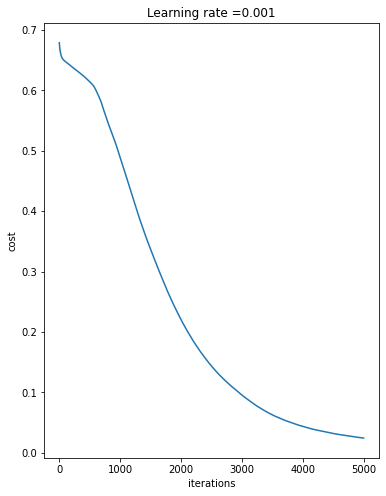

In [ ]:
# Train the DNN model with 3 hidden layers of size 20, 5, 7, respectively in 5000 iterations at learning rate = 0.001
# Your code here
parameters = dnn_model(X_train, y_train, [20, 5, 7], 5000, 0.001)

# Make predictions on the test set using the trained model
# Your code here
predictions = predict(X_test, parameters)

In [ ]:
# Check accuracy
# Your should get Accuracy Score = 0.740000
print("Accuracy Score: %f" % accuracy_score(y_test[0], predictions[0]))
print("Confusion Matrix:")
print(confusion_matrix(y_test[0], predictions[0]))

Accuracy Score: 0.760000
Confusion Matrix:
[[11  6]
 [ 6 27]]


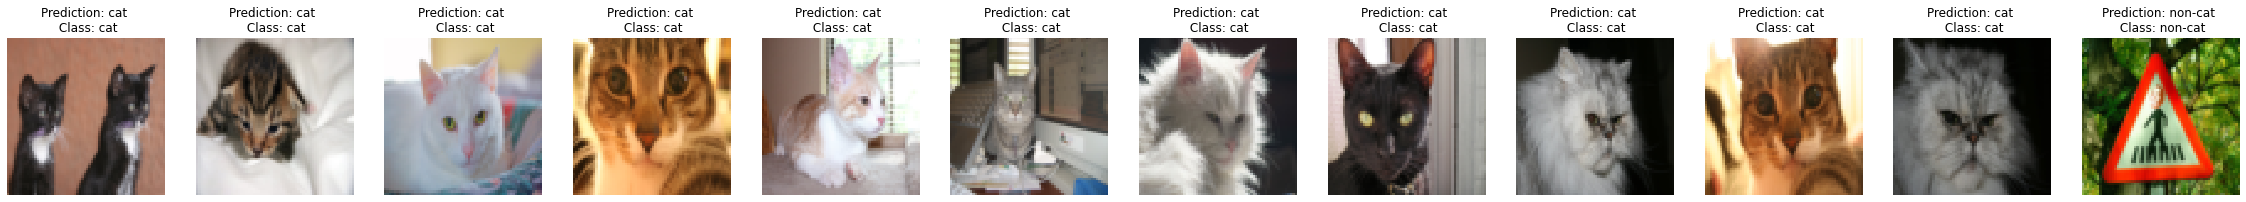

In [ ]:
# Print mislabeled images
def print_correct_images(classes, X, y, p):
    a = p + y
    correct_indices = np.asarray(np.where(a != 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    # num_images = len(correct_indices[0])
    num_images = 12
    for i in range(num_images):
        index = correct_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[index, :].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

print_correct_images(classes, X_test, y_test, predictions)

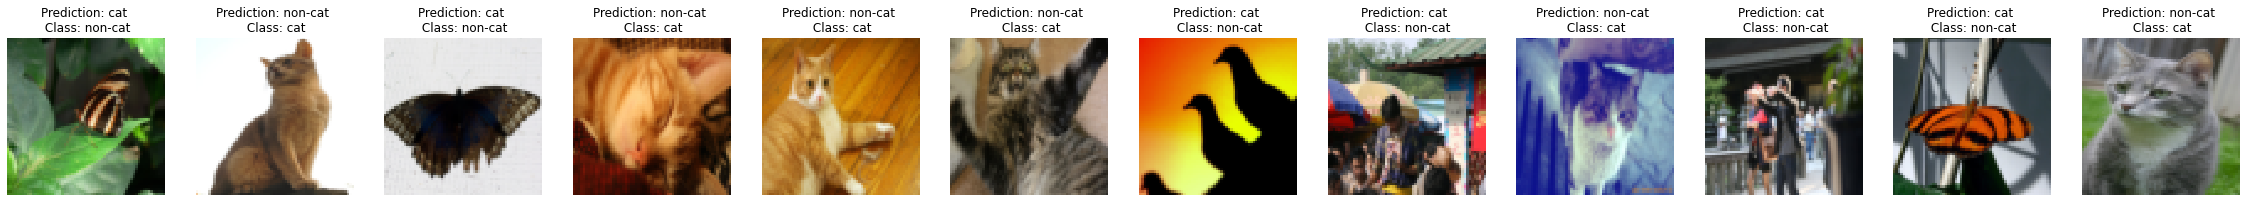

In [ ]:
# Print mislabeled images
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[index, :].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

print_mislabeled_images(classes, X_test, y_test, predictions)